In [9]:
from carla import Benchmark
from IPython.display import display
import carla.evaluation.catalog as evaluation_catalog
from carla.data.catalog import OnlineCatalog
from carla.models.catalog import MLModelCatalog
from carla.models.negative_instances import predict_negative_instances
import carla.recourse_methods.catalog as recourse_catalog
import shap 
from sklearn.preprocessing import OrdinalEncoder
from carla.data.causal_model import CausalModel
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from carla.data.catalog import CsvCatalog
import numpy as np 

import warnings
warnings.filterwarnings("ignore")

In [10]:
scm = CausalModel("credit")

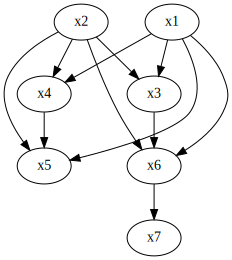

In [11]:
scm.cgm.draw()

In [12]:

dataset = scm.generate_dataset(1000)
dataset.df.to_csv('credit_synthetic.csv',index=False)
display(dataset.df)

,label,x1,x2,x3,x4,x6,x5,x7
0,1.0,0.0,6.565484,-0.127141,-1.884842,0.687208,-8.580016,3.702616
1,0.0,0.0,-14.256430,-0.254264,0.781183,-0.660207,-1.167788,-4.059172
2,0.0,1.0,-2.246499,0.211444,0.325020,0.613889,0.582314,-3.908564
3,1.0,0.0,7.202792,0.009104,-0.433099,-0.320645,-4.374409,0.665991
4,0.0,0.0,-7.132973,-0.366671,1.227069,-1.500139,-1.986092,-10.807399
...,...,...,...,...,...,...,...,...
995,0.0,1.0,-2.973493,0.039866,0.170625,3.233812,-1.315281,-2.491177
996,0.0,1.0,-10.667505,-0.025353,1.779956,-0.435844,6.290502,-5.860527
997,0.0,0.0,1.343010,-0.164597,-2.796275,-0.037198,-4.245947,-3.827892
998,0.0,0.0,-4.704241,-0.301684,-0.418927,-0.553536,-0.139668,-3.060095


In [13]:
'''Build Dataset for Wachter'''
import pandas as pd
# Load Data 
dataframe = pd.read_csv('./credit_synthetic.csv')
continuous = dataframe.drop(columns=['label']).columns

dataset = CsvCatalog(file_path="credit_synthetic.csv",
                     continuous=continuous,
                     categorical=[],
                     immutables=[],
                     target='label')

In [14]:
#Model 

training_params = {"lr": 0.01, "epochs": 3, "batch_size": 16, "hidden_size": [18, 9, 2]}

ml_model = MLModelCatalog(
    dataset, model_type="ann", load_online=False, backend="pytorch"
)
ml_model.train(
    learning_rate=training_params["lr"],
    epochs=training_params["epochs"],
    batch_size=training_params["batch_size"],
    hidden_size=training_params["hidden_size"],
    force_train=True
)


balance on test set 0.4746666666666667, balance on test set 0.516
Epoch 0/2
----------
train Loss: 0.6072 Acc: 0.6693

test Loss: 0.4798 Acc: 0.7640

Epoch 1/2
----------
train Loss: 0.4832 Acc: 0.7987

test Loss: 0.4387 Acc: 0.8240

Epoch 2/2
----------
train Loss: 0.4190 Acc: 0.8187

test Loss: 0.4009 Acc: 0.8000



In [15]:
from carla.models.negative_instances import predict_negative_instances
import carla.recourse_methods.catalog as recourse_catalog

factuals = predict_negative_instances(ml_model, dataset.df)
test_factual = factuals.iloc[:25]

display(test_factual)

,label,x1,x2,x3,x4,x6,x5,x7
1,0.0,0.0,0.143734,0.165540,0.810495,0.370833,0.510227,0.361149
4,0.0,0.0,0.228745,0.017974,0.823643,0.322279,0.486397,0.174993
7,0.0,0.0,0.232048,0.400338,0.737867,0.341644,0.494952,0.312910
9,0.0,0.0,0.206001,0.380851,0.797664,0.463804,0.517025,0.323897
10,1.0,1.0,0.187292,0.260196,0.818064,0.621223,0.570338,0.335291
11,0.0,0.0,0.209172,0.259592,0.816292,0.290155,0.503830,0.474915
14,0.0,0.0,0.272978,0.210271,0.703478,0.324142,0.313070,0.204666
16,0.0,0.0,0.246736,0.276878,0.796092,0.254106,0.488292,0.414673
18,0.0,0.0,0.141846,0.151604,0.723928,0.354254,0.442283,0.118439
19,0.0,0.0,0.219060,0.150989,0.742418,0.641711,0.409117,0.486277


In [16]:
hyperparams = {"loss_type": "BCE"}

recourse_method = recourse_catalog.Wachter(ml_model, hyperparams)
cfs = recourse_method.get_counterfactuals(test_factual)


[INFO] Timeout - No Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Timeout - No Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Timeout - No Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Timeout - No Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Timeout - No Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Timeout - No Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Timeout - No Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Timeout - No Counterfactual Explanation Found [wachter.py wach

In [17]:
def get_pred_from_causal(scm,values,cf_label, mapping_dict):
    #TODO change everything hard coded
    values['target']=cf_label
    def _get_noise_string(node):
        def _get_node_id(node):
            return node[1:]
        if not node[0] == "x":
            raise ValueError
        return "u" + _get_node_id(node)
    exogenous_variables = np.concatenate(
        [
            np.array(values[mapping_dict[node]]).reshape(-1, 1)
            for node in scm.get_topological_ordering("exogenous")
        ],
        axis=1,
    )
    exogenous_variables = pd.DataFrame(
        exogenous_variables, columns=scm.get_topological_ordering("exogenous")
    )

    endogenous_variables = exogenous_variables.copy()
    endogenous_variables = endogenous_variables.rename(
        columns=dict(
            zip(
                scm.get_topological_ordering("exogenous"),
                scm.get_topological_ordering("endogenous"),
            )
        )
    )
    # used later to make sure parents are populated when computing children
    endogenous_variables.loc[:] = np.nan
    for node in scm.get_topological_ordering("endogenous"):
        parents = scm.get_parents(node)
        if endogenous_variables.loc[:, list(parents)].isnull().values.any():
            raise ValueError(
                "parents in endogenous_variables should already be occupied"
            )
        endogenous_variables[node] = scm.structural_equations_np[node](
            exogenous_variables[_get_noise_string(node)],
            *[endogenous_variables[p] for p in parents],
        )
    labels=endogenous_variables['x7'][0]
    return labels

In [18]:
mapping_dict={ 
    # Gender
      'u1': 'x1',
      # Age
      'u2': 'x2',
      # Education
      'u3': 'x3',
      # Loan amount
      'u4':'x4',
      # Loan duration
      'u5': 'x5',
      # Income
      'u6': 'x6',
      # Savings
      'u7':'x7',
}

In [56]:
from cmath import nan
from telnetlib import SE
from carla.data import causal_model
from carla.evaluation import remove_nans
from carla.evaluation.api import Evaluation
class Sematic(Evaluation):
    """
    Semnatic Evaluation Metric.
    Attributes: 
        ml_model: Machine Learning Model
        causal_graph: ground truth causal graph
        mapping_dict: name mapping
    """

    def __init__(self, ml_model, causal_graph,mapping_dict):
        self.ml_model= ml_model
        self.causal_graph=causal_graph
        self.mapping_dict=mapping_dict
    def get_evaluation(self,factuals: np.ndarray, counterfactuals: np.ndarray):
        # generate data 
        cf_label=self.ml_model.predict(np.array(counterfactuals.values).reshape(-1,counterfactuals.values.shape[-1]))
        print(cf_label)
        if cf_label[0][0] > 0.5: 
            cf_label=1
        else:
            cf_label=0
        print(cf_label)
        #cf_label=np.argmax(cf_label)
        causal_label=get_pred_from_causal(self.causal_graph,counterfactuals,cf_label, self.mapping_dict)
        #print(cf_label)
        print(causal_label)
        if cf_label ==causal_label:
            return pd.DataFrame([[1]], columns=["semantic"])
        else: 
            return pd.DataFrame([[0]], columns=["semantic"])
'''Histogram Features / true Positive / false Positive'''
# first initialize the benchmarking class by passing
# black-box-model, recourse method, and factuals into it#
results=[]
i=0
#print(factuals.iloc[:20])
for a in test_factual.index:
    #print(test_factual.index)

    if str(cfs.iloc[i]['x1'])=='nan':
        pass
    else:
        sem= Sematic(ml_model,scm,mapping_dict)
        try:
            results.append( sem.get_evaluation(test_factual.iloc[a],cfs.iloc[i])['semantic'][0])
        except: 
            pass
    i=i+1


#benchmark = Benchmark(ml_model, recourse_method, factuals[:20])

# now you can decide if you want to run all measurements
# or just specific ones.
#evaluation_measures = [
#    Sematic(ml_model,scm,mapping_dict)
#]

#results = benchmark.run_benchmark(evaluation_measures)
results


[[0.5553267]]
1
-3.6279610693454742
[[0.5020534]]
1
-3.6266010999679565
[[0.50682944]]
1
-3.634854793548584
[[0.53604466]]
1
-3.4838947057724
[[0.5042931]]
1
-3.622609943151474


[0, 0, 0, 0, 0]

In [57]:
# Box Plot of
mean= np.mean(results)
std= np.std(results)
print(f'Semantic results {mean} +/- {std}')

Semantic results 0.0 +/- 0.0


In [71]:
np.argwhere(np.array(results)==0)

array([[0],
       [1],
       [2],
       [3],
       [4]])

In [97]:
import seaborn as sns 
import matplotlib.pyplot as plt 
# Data Distribution
id_comp= np.where(np.array(results)==1)
id_not_comp=np.where(np.array(results)==0)
print(id_not_comp)
if len(id_comp[0])==0:
    cfs_complient=[]
    cfs_complient_predict=[]
    
else:
    cfs_complient=cfs[id_comp]
    cfs_complient_predict=np.max(ml_model.predict(np.array(cfs_complient.values).reshape(-1,cfs_complient.values.shape[-1])),axis=1)

print(id_not_comp[0])
cfs_not_complient=cfs.iloc[id_not_comp[0]]

print(cfs_not_complient)
#TODO

cfs_not_complient_predict=np.max(ml_model.predict(np.array(cfs_not_complient).reshape(-1,7)),axis=1)
print(cfs_not_complient_predict)

#df_complient = pd.DataFrame(np.array([cfs_complient_predict,cfs_not_complient_predict]), columns=['complient','not complient'])

(array([0, 1, 2, 3, 4]),)
[0 1 2 3 4]
          x1        x2        x3        x4        x5        x6        x7
1        NaN       NaN       NaN       NaN       NaN       NaN       NaN
4        NaN       NaN       NaN       NaN       NaN       NaN       NaN
7   0.059155  0.291182  0.459450  0.678755  0.554063  0.400772  0.372039
9   0.049500  0.255509  0.430345  0.748173  0.566518  0.513306  0.373399
10  1.029597  0.217151  0.290049  0.788216  0.600190  0.651078  0.365145
[       nan        nan 0.55532676 0.5020533  0.5068292 ]


[0.55532676 0.5020533  0.5068292 ]


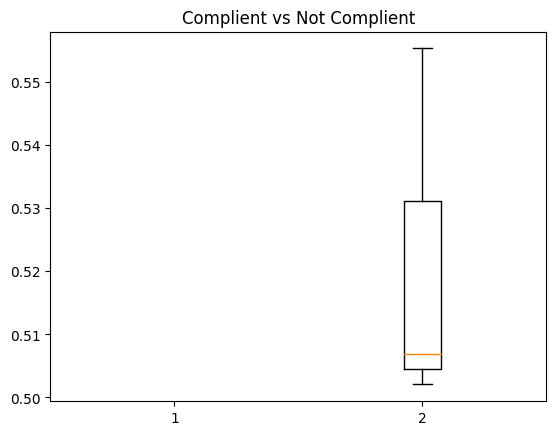

In [99]:
#BoxPlot
# Drob na 
import  numpy
from math import nan, isnan
cfs_complient_predict = [x for x in cfs_complient_predict if isnan(x) == False]
cfs_not_complient_predict = [x for x in cfs_not_complient_predict if isnan(x) == False]
cfs_complient_predict=np.array(cfs_complient_predict).reshape(-1)
cfs_not_complient_predict=np.array(cfs_not_complient_predict).reshape(-1)

print(cfs_not_complient_predict)
data = [cfs_complient_predict,cfs_not_complient_predict]

fig7, ax7 = plt.subplots()
ax7.set_title('Complient vs Not Complient')
ax7.boxplot(data)

#plt.ylim((0.99,1))
plt.show()

In [ ]:
# Violin Plot 
